<a href="https://colab.research.google.com/github/sungshin98/kci/blob/main/kci_klue_roberta_base_its_real_with_LSTM%26CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


wav 디렉토리에서 .txt 파일의 개수를 찾음

In [2]:
'''
import os

directory = '/content/drive/MyDrive/wav'
total_files = 0

# 디렉토리 순회
for root, dirs, files in os.walk(directory):
    # txt 파일 개수 계산
    txt_files = [file for file in files if file.endswith('.txt')]
    total_files += len(txt_files)

print("총 txt 파일 개수:", total_files)
'''

'\nimport os\n\ndirectory = \'/content/drive/MyDrive/wav\'\ntotal_files = 0\n\n# 디렉토리 순회\nfor root, dirs, files in os.walk(directory):\n    # txt 파일 개수 계산\n    txt_files = [file for file in files if file.endswith(\'.txt\')]\n    total_files += len(txt_files)\n\nprint("총 txt 파일 개수:", total_files)\n'

In [3]:
!pip install transformers
!pip install tensorflow_addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 13.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 26.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 29.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 29.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 612.1/612.1 kB 5.9 MB/s eta 0:00:00


In [4]:
import os
import pandas as pd
import numpy as np
import re
from tqdm import tqdm
import urllib.request
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow_addons as tfa
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from transformers import TFRobertaForSequenceClassification, RobertaTokenizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, \
                            roc_auc_score, confusion_matrix, classification_report, \
                            matthews_corrcoef, cohen_kappa_score, log_loss

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [5]:
from transformers import AutoTokenizer,TFAutoModel

model = TFAutoModel.from_pretrained("klue/roberta-base")
tokenizer = AutoTokenizer.from_pretrained("klue/roberta-base")

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaModel: ['lm_head.dense.weight', 'roberta.embeddings.position_ids', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.bias', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing TFRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaModel were not initialized from the PyTorch model and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and infe

In [6]:
device_name = tf.test.gpu_device_name()
if device_name == '/device:GPU:0':
  print("GPU 작동 중")
  mirrored_strategy = tf.distribute.MirroredStrategy()
else:
  print("GPU 미작동 중")

GPU 작동 중


annotation 내의 파일들과 wav 디렉토리 내의 txt 파일들을 매칭하여
새로운 csv 파일 만듦 (스크립트와 감정 매칭)


In [7]:
import os
import pandas as pd

# 데이터를 담을 빈 리스트 생성
data = []

# 디렉토리 순회
directory = '/content/drive/MyDrive/wav'
eval_directory = '/content/drive/MyDrive/annotation'
for session in range(1, 41):
    session_dir = os.path.join(directory, f"Session{session:02d}")
    eval_file = os.path.join(eval_directory, f"Sess{session:02d}_eval.csv")
    if os.path.exists(session_dir) and os.path.exists(eval_file):
        eval_data = pd.read_csv(eval_file)
        for filename in os.listdir(session_dir):
            if filename.endswith(".txt"):
                txt_file = os.path.join(session_dir, filename)
                with open(txt_file, 'r' , encoding='cp949') as f:
                    segment_id = os.path.splitext(filename)[0]
                    sentiment = f.read().strip()
                    try:
                        total_evaluation = eval_data[eval_data['Segment ID'] == segment_id]['Total Evaluation'].values[0]
                    except IndexError:
                        total_evaluation = "Unknown"
                    data.append([segment_id, sentiment, total_evaluation])

# DataFrame으로 변환하고 CSV 파일로 저장
df = pd.DataFrame(data, columns=['Segment ID','Sentiment', 'Total Evaluation'])
df.to_csv('/content/drive/MyDrive/wav/sentiment_evaluation_with_LSTM&CNN.csv', index=False)


In [102]:
df = pd.read_csv('/content/drive/MyDrive/wav/sentiment_evaluation_with_LSTM&CNN.csv')
df_append = pd.read_csv('/content/drive/MyDrive/wav/LSTM_CNN_prediction.csv')

df=df.sort_values(by="Segment ID")
print(df.head(), df_append)

                       Segment ID  \
309  Sess01_script01_User001F_001   
308  Sess01_script01_User001F_002   
307  Sess01_script01_User001F_003   
303  Sess01_script01_User001F_004   
300  Sess01_script01_User001F_005   

                                             Sentiment Total Evaluation  
309                                      n/ 아 친구들도? l/          neutral  
308                                          l/ 나는 생일?          neutral  
307  생일날이면은 b/ 내가 고기를 되게 좋아하니까 엄마도 그걸 아니까 미역국도 같이 해...          neutral  
303                           b/ 선물이라 이 보통 돈으로 주시지. l/            happy  
300                                       l/ 용돈으로 주시고.          neutral                               Session  emotion     sentence
0      Sess01_script01_User001F_001  disgust     진짜 소름 끼쳐
1      Sess01_script01_User001F_002    angry  그래서 나는 화가 나
2      Sess01_script01_User001F_003      sad   그래서 나는 울었어
3      Sess01_script01_User001F_004    angry  그래서 나는 화가 나
4      Sess01_script01_User001F_005    angr

In [103]:
count=0


df=df.sort_values(by="Segment ID")

# "Segment ID"와 "Session"이 일치하는 행에 "sentence" 값을 추가
for i in df.index:
    segment_id = df.at[i, "Segment ID"]
    session = df_append.at[count, "Session"]

    if segment_id == session:
        df.at[i, "Sentiment"] = df.at[i, "Sentiment"] + df_append.at[count, "sentence"]
        print(df.at[i,"Sentiment"])
        count += 1
    if count == len(df_append):
        break  # df_append를 모두 사용한 경우 종료

print(df)

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
근데 친구가 몸은 일자로 있고 여기 머리를 90도로 꺾어가지고 벽에 코를 박고서 자고 있는 거야.그래서 나는 행복해
근데 코 코까지고니까 그게 벽 가지 통과돼가지고 우리 귀에 들리는 거야 어 얼마나 컸겠어 소리가 그래가지고 잠 못 잤던 경험도 있고.그래서 나는 행복해
또 몽유병?.그래서 나는 행복해
나어렸을 때 있었지.그래서 나는 행복해
으응 어렸을 땐 다 있대.그래서 나는 행복해
이거 친구가 친구한테 겪은 거야 이것도.그래서 나는 행복해
흐흐 아니 초 초등학교 때였어 그때가 아직도 기억나 그 무서움이.그래서 나는 행복해
근데 나랑 어떤 애랑 같은 방이 됐는데 그렇게 친한 애가 아니었어 근데 걔가 나는 잠 좀 늦게 잠들었는데 걔가 자다가 갑자기 그전에 나한테 얘기했어 나몽유병있으니까.그래서 나는 무서웠어
c/ 혹시라도 좀 그러면 좀 그렇게 이해해달라 그러는 거야나는 나한테 피해만 안 오면 되니까 그랬지 근데 갑자기 뭔가 난 벽을 보고서 보고 있었어 핸드폰이랑.그래서 나는 무서웠어
눈을 감은 상태로.그래서 나는 무서웠어
그래가지고 내 앞에 침대로 걸어오는 거야 자기 침대에서 일어나가지고 침대에 부딪혔을 거 아니야 딱 부딪힌 순간 또 가만히 있어 그러다가 또 옆으로 옆으로 슥 돌아 문까지 걸어가는 거야.그래서 나는 무서웠어
u/ 어어어 그러니까 나한테 양해를 구한 거지 심하니까.그래서 나는 무서웠어
어 난 난 그 정도로 한 적 있어 학교에서 자다가 시험 시험시간이었는데 중학교때 였을거야 하고서 자고 있었어 누워서 근데 뭐야.진짜 소름 끼쳐
너 나? 나는 내가 이제 대학교 때 좀 둥글게 둥글게 사는 게 모토였거든? 근데 이제 내가 흐흐 내가 이제 부 학회장 하고 이렇게 학생회 하 그 그거 하기 전에 학생회를 했었어.그래서 나는 화가 나
그 좀 당황해가지고 별말 안 하긴 했는데 나는 그때 아 이 사람 좀 꼰대구나 그때 느꼈던 기억이 있었어.그래서 나는 화가 나
어 그치 아니 근데 그냥 일도 아니고 누구 

In [104]:
df.to_csv('/content/drive/MyDrive/wav/LSTM_CNN_eval_ver1.csv', index=False)
df = pd.read_csv('/content/drive/MyDrive/wav/LSTM_CNN_eval_ver1.csv')

In [106]:
df[df['Total Evaluation'] == "Unknwon"] #결측치

,Segment ID,Sentiment,Total Evaluation


In [107]:
# 합칠 값들과 합칠 기준값 설정
values_to_merge = ["happy;neutral", "angry;neutral", "neutral;sad", "surprise;neutral", "neutral;disqust", "happy;surprise", "angry;disqust",
                   "happy;fear", "angry;neutral;disqust", "happy;sad", "neutral;disqust;sad", "angry;neutral;disqust;fear;sad",
                   "happy;surprise;neutral", "happy;angry;neutral", "Unknown", "happy;neutral;disqust", "happy;neutral;fear", "neutral;fear"]

# 합칠 값들을 하나의 값으로 합치기
for value in values_to_merge:
    merged_value = value.split(';')[0]  # 합칠 값들 중 첫 번째 값을 선택하여 합칠 값으로 사용
    df['Total Evaluation'] = df['Total Evaluation'].replace(value, merged_value)

df=df[df['Total Evaluation']!='Unknown']  # 결측치 제거

print(df['Total Evaluation'].value_counts())


neutral     11249
happy        1543
angry         233
surprise      212
sad           121
disqust        61
fear           43
Name: Total Evaluation, dtype: int64


In [108]:
# 감정을 숫자로 변환
df['Total Evaluation'] = df['Total Evaluation'].replace(['neutral', 'happy', 'angry', 'surprise', 'sad', 'disqust', 'fear'] ,[0, 1, 2, 3, 4, 5, 6])

# 영어와 특수문자 제외한 문자 제거 함수 정의 (\n 과 같은 문제 제거)
def remove_special_characters(text):
    processed_text = re.sub(r"[^가-힣.]", " ", text)
    return processed_text

# 'Sentiment' 열에 함수 적용
df['Sentiment'] = df['Sentiment'].apply(remove_special_characters)



<ipython-input-108-f0cbb6b7f4f6>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Total Evaluation'] = df['Total Evaluation'].replace(['neutral', 'happy', 'angry', 'surprise', 'sad', 'disqust', 'fear'] ,[0, 1, 2, 3, 4, 5, 6])
<ipython-input-108-f0cbb6b7f4f6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Sentiment'] = df['Sentiment'].apply(remove_special_characters)


In [109]:
df["Total Evaluation"].value_counts()

0    11249
1     1543
2      233
3      212
4      121
5       61
6       43
Name: Total Evaluation, dtype: int64

In [110]:
X_data = df['Sentiment']
y_data = df['Total Evaluation']

df.info() #Non=Null임을 확인
df[df['Sentiment'].duplicated()]

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13462 entries, 0 to 13462
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Segment ID        13462 non-null  object
 1   Sentiment         13462 non-null  object
 2   Total Evaluation  13462 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 420.7+ KB


,Segment ID,Sentiment,Total Evaluation
7882,Sess25_script01_User049M_040,패밀리가 떴다.그래서 나는 무서웠어,0
8301,Sess25_script06_User050F_020,그럴 수 있지.그래서 나는 행복해,0
10299,Sess32_script03_User064F_008,너무 좋아.그래서 나는 무서웠어,0
10461,Sess32_script05_User063M_043,그럴 거 같애.진짜 소름 끼쳐,0
11709,Sess36_script02_User072F_019,뭔지 알아 진짜 소름 끼쳐,1


중복되는 값이 있는지 확인하고 제거

In [111]:
'''
DATASET_PREP_FILE = '/content/drive/MyDrive/wav/sentiment_evaluation.csv'
# 중복 데이터 제거
df.drop_duplicates(subset = ['Sentiment'], inplace = True)
df.to_csv(DATASET_PREP_FILE) # 구글 드라이브 내 data 폴더에 저장
'''

"\nDATASET_PREP_FILE = '/content/drive/MyDrive/wav/sentiment_evaluation.csv'\n# 중복 데이터 제거\ndf.drop_duplicates(subset = ['Sentiment'], inplace = True)\ndf.to_csv(DATASET_PREP_FILE) # 구글 드라이브 내 data 폴더에 저장\n"

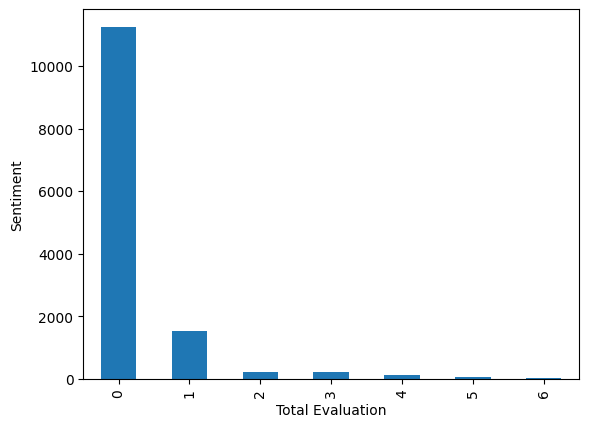

In [112]:
df['Total Evaluation'].value_counts().plot(kind = 'bar')
plt.xlabel("Total Evaluation")
plt.ylabel("Sentiment")
plt.show()

In [113]:
lengths=[len(row) for row in df['Sentiment']]
print(np.mean(lengths))
print(np.std(lengths))
print(np.var(lengths))

45.12843559649384
30.326533404766902
919.6986283504428


In [114]:


TEST_SIZE = 0.2 # Train: Test = 8 :2 분리
RANDOM_STATE = 42
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data,
                                                    test_size = TEST_SIZE,
                                                    random_state = RANDOM_STATE,
                                                    stratify = y_data)

print(f"훈련 입력 데이터 개수: {len(X_train)}")
print(f"테스트 입력 데이터 개수: {len(X_test)}")

# 훈련 데이터 라벨별 비율
print(y_train.value_counts(normalize = True))

# 테스트 데이터 라벨별 비율
print(y_test.value_counts(normalize = True))

훈련 입력 데이터 개수: 10769
테스트 입력 데이터 개수: 2693
0    0.835639
1    0.114588
2    0.017272
3    0.015786
4    0.009007
5    0.004550
6    0.003157
Name: Total Evaluation, dtype: float64
0    0.835499
1    0.114742
2    0.017453
3    0.015596
4    0.008912
5    0.004456
6    0.003342
Name: Total Evaluation, dtype: float64


In [115]:
# 입력 데이터(문장) 길이 제한
MAX_SEQ_LEN = 70

def convert_data(X_data, y_data):
    # BERT 입력으로 들어가는 token, mask, segment, target 저장용 리스트
    tokens, masks, targets = [], [], []

    for X, y in tqdm(zip(X_data, y_data)):
        # token: 입력 문장 토큰화
        token = tokenizer.encode(X, truncation=True, padding='max_length', max_length=MAX_SEQ_LEN)

        # mask: 패딩이 아닌 경우 1, 패딩인 경우 0으로 초기화
        mask = [1] * len(token) + [0] * (MAX_SEQ_LEN - len(token))

        tokens.append(token)
        masks.append(mask)
        targets.append(tf.one_hot(y, depth=7))  # 타깃 데이터를 원-핫 인코딩

    # numpy array로 저장
    tokens = np.array(tokens)
    masks = np.array(masks)
    targets = np.array(targets)

    return [tokens, masks], targets  # train 데이터를 Bert의 Input 타입에 맞게 변환

In [116]:
# train 데이터를 Bert의 Input 타입에 맞게 변환
train_x, train_y = convert_data(X_train, y_train)

# test 데이터를 Bert의 Input 타입에 맞게 변환
test_x, test_y = convert_data(X_test, y_test)

10769it [00:04, 2625.48it/s]
2693it [00:01, 2540.26it/s]


In [117]:
# token, mask 입력 정의
token_inputs = tf.keras.layers.Input((MAX_SEQ_LEN,), dtype = tf.int32, name = 'input_word_ids')
mask_inputs = tf.keras.layers.Input((MAX_SEQ_LEN,), dtype = tf.int32, name = 'input_masks')
bert_outputs = model(token_inputs, mask_inputs)



In [118]:
bert_output = bert_outputs[0][:, 0, :]

DROPOUT_RATE = 0.5
NUM_CLASS = 7
dropout = tf.keras.layers.Dropout(DROPOUT_RATE)(bert_output)
# Multi-class classification 문제이므로 activation function은 softmax로 설정
sentiment_layer = tf.keras.layers.Dense(NUM_CLASS, activation='softmax', kernel_initializer = tf.keras.initializers.TruncatedNormal(stddev=0.02))(dropout)
sentiment_model = tf.keras.Model([token_inputs, mask_inputs], sentiment_layer)

# 옵티마이저 Rectified Adam 하이퍼파리미터 조정
OPTIMIZER_NAME = 'RAdam'
LEARNING_RATE = 1e-5
TOTAL_STEPS = 10000
MIN_LR = 1e-5
WARMUP_PROPORTION = 0.1
EPSILON = 1e-8
CLIPNORM = 1.0
optimizer = tfa.optimizers.RectifiedAdam(learning_rate = LEARNING_RATE,
                                          total_steps = TOTAL_STEPS,
                                          warmup_proportion = WARMUP_PROPORTION,
                                          min_lr = MIN_LR,
                                          epsilon = EPSILON,
                                          clipnorm = CLIPNORM)


# 감정분류 모델 컴파일
sentiment_model.compile(optimizer=optimizer,
                        loss=tf.keras.losses.CategoricalCrossentropy(),
                        metrics=['accuracy'])

MIN_DELTA = 1e-3
PATIENCE = 5

early_stopping = EarlyStopping(
    monitor = "val_accuracy",
    min_delta = MIN_DELTA,
    patience = PATIENCE)

# 최고 성능의 모델 파일을 저장할 이름과 경로 설정
BEST_MODEL_NAME = 'best_model.h5'
model_checkpoint = ModelCheckpoint(
    filepath = BEST_MODEL_NAME,
    monitor = "val_loss",
    mode = "min",
    save_best_only = True, # 성능 향상 시에만 모델 저장
    verbose = 1
)

callbacks = [early_stopping, model_checkpoint]

In [119]:
EPOCHS = 100
BATCH_SZIE = 32

sentiment_model.fit(train_x, train_y,
                    epochs = EPOCHS,
                    shuffle = True,
                    batch_size = BATCH_SZIE,
                    validation_data = (test_x, test_y),
                    callbacks = callbacks
                    )

Epoch 1/100


337/337 [==============================] - ETA: 0s - loss: 1.3531 - accuracy: 0.5525
Epoch 1: val_loss improved from inf to 0.63877, saving model to best_model.h5
337/337 [==============================] - 235s 597ms/step - loss: 1.3531 - accuracy: 0.5525 - val_loss: 0.6388 - val_accuracy: 0.8355
Epoch 2/100
337/337 [==============================] - ETA: 0s - loss: 0.6379 - accuracy: 0.8341
Epoch 2: val_loss improved from 0.63877 to 0.63300, saving model to best_model.h5
337/337 [==============================] - 208s 618ms/step - loss: 0.6379 - accuracy: 0.8341 - val_loss: 0.6330 - val_accuracy: 0.8355
Epoch 3/100
337/337 [==============================] - ETA: 0s - loss: 0.6131 - accuracy: 0.8356
Epoch 3: val_loss improved from 0.63300 to 0.58489, saving model to best_model.h5
337/337 [==============================] - 204s 605ms/step - loss: 0.6131 - accuracy: 0.8356 - val_loss: 0.5849 - val_accuracy: 0.8355
Epoch 4/100
337/337 [==============================] - ETA: 0s - loss: 0.5

In [120]:
output=sentiment_model.predict(test_x)

# 'sentiment_model.predict(test_x)'의 출력이 'output' 변수에 저장되어 있다고 가정합니다.
# 실제 변수 이름이 'output'이 아니라면 해당 변수 이름으로 바꿔주세요.

# 각 리스트(배열)에서 가장 큰 값의 인덱스를 찾습니다.
max_indices = np.argmax(output, axis=1)

print(max_indices)

s1=0
s2=0
s3=0
s4=0
s5=0
s6=0
s7=0
for i in max_indices:
    if i == 0:
        s1=s1+1
    elif i == 1:
        s2=s2+1
    elif i == 2:
        s3=s3+1
    elif i == 3:
        s4=s4+1
    elif i == 4:
        s5=s5+1
    elif i == 5:
        s6=s6+1
    else:
        s7=s7+1

print("neutral: ", s1)
print("happy: ", s2)
print("angry: ", s3)
print("surprise: ", s4)
print("sad: ", s5)
print("disqust: ", s6)
print("fear: ", s7)


85/85 [==============================] - 16s 157ms/step
[0 0 1 ... 0 0 2]
neutral:  2427
happy:  183
angry:  26
surprise:  24
sad:  23
disqust:  4
fear:  6


In [137]:
# 예측할 텍스트 입력
test_text ="깜짝 놀랐네"  #그래서 난 행복해, 그래서 난 화가 나, 그래서 난 놀랐어, 그래서 난 울었어, 진짜 극혐, 그래서 난 무서워

# 텍스트 토크나이징 및 변환
test_inputs, _ = convert_data([test_text], [0])

# 입력 데이터를 텐서로 변환 (numpy array를 TensorFlow tensor로 변환)
input_ids = tf.constant(test_inputs[0])
attention_mask = tf.constant(test_inputs[1])

# 모델 예측
with tf.device('/CPU:0'):  # CPU 사용으로 설정
    outputs = sentiment_model.predict([input_ids, attention_mask])

# 로짓값 얻기
logits = outputs[0]

# 소프트맥스 함수를 통해 확률 계산
probabilities = tf.nn.softmax(logits, axis=-1).numpy()

# 가장 높은 확률을 가진 클래스를 예측 결과로 선택
predicted_classes = tf.argmax(probabilities, axis=-1).numpy()

# 로짓값과 예측 결과 출력
print("text:",test_text)
#print("Logits values:", logits)
#print("Probabilities:", probabilities)
print("가장 높은 감정 비율:", int(probabilities.max()*100),"%")

class_labels = ['neutral', 'happy', 'angry', 'surprised', 'sad', 'disgust', 'fear']

# 가장 높은 확률을 가진 클래스를 예측 결과로 선택
predicted_class = tf.argmax(probabilities, axis=-1).numpy()

# 예측된 클래스를 문자열로 출력
predicted_emotion = class_labels[predicted_class]

print(f"예측 감정: {predicted_emotion}")

1it [00:00, 345.18it/s]


1/1 [==============================] - 0s 420ms/step
text: 깜짝 놀랐네
가장 높은 감정 비율: 24 %
예측 감정: surprised


In [122]:
'''
text: 아 깜짝이야.
가장 높은 감정 비율: 23 %
예측 감정: surprised

text: 아 깜짝이야. 그래서 난 놀랐어.
가장 높은 감정 비율: 27 %
예측 감정: surprised

text: 진짜 슬프더라.
가장 높은 감정 비율: 20 %
예측 감정: sad

text: 진짜 슬프더라. 그래서 난 울었어.
가장 높은 감정 비율: 28 %
예측 감정: sad

text: 왜 날 짜증나게 하는거야?
가장 높은 감정 비율: 26 %
예측 감정: angry

text: 왜 날 짜증나게 하는거야? 그래서 난 화가 나
가장 높은 감정 비율: 29 %
예측 감정: angry

text: 아 나 진짜 싫어
가장 높은 감정 비율: 22 %
예측 감정: surprised

text: 아 나 진짜 싫어. 진짜 극혐
가장 높은 감정 비율: 25 %
예측 감정: disgust

text: 고마워 너 덕분이야
가장 높은 감정 비율: 29 %
예측 감정: happy

text: 고마워 너 덕분이야. 그래서 난 행복해
가장 높은 감정 비율: 24 %
예측 감정: happy
'''

'\ntext: 아 깜짝이야.\n가장 높은 감정 비율: 23 %\n예측 감정: surprised\n\ntext: 아 깜짝이야. 그래서 난 놀랐어.\n가장 높은 감정 비율: 27 %\n예측 감정: surprised\n\ntext: 진짜 슬프더라.\n가장 높은 감정 비율: 20 %\n예측 감정: sad\n\ntext: 진짜 슬프더라. 그래서 난 울었어.\n가장 높은 감정 비율: 28 %\n예측 감정: sad\n\ntext: 왜 날 짜증나게 하는거야?\n가장 높은 감정 비율: 26 %\n예측 감정: angry\n\ntext: 왜 날 짜증나게 하는거야? 그래서 난 화가 나\n가장 높은 감정 비율: 29 %\n예측 감정: angry\n\ntext: 아 나 진짜 싫어\n가장 높은 감정 비율: 22 %\n예측 감정: surprised\n\ntext: 아 나 진짜 싫어. 진짜 극혐\n가장 높은 감정 비율: 25 %\n예측 감정: disgust\n\ntext: 고마워 너 덕분이야\n가장 높은 감정 비율: 29 %\n예측 감정: happy\n\ntext: 고마워 너 덕분이야. 그래서 난 행복해\n가장 높은 감정 비율: 24 %\n예측 감정: happy\n'